In [29]:
!pip -q install datasets huggingface_hub pyarrow pandas numpy matplotlib


In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

SEED = 42
np.random.seed(SEED)


METR-LA is a traffic sensor network in Los Angeles.

Nodes = fixed road sensors (loop detectors)

Each node measures traffic conditions at regular intervals
(typically speed, sometimes flow)

Sensors are arranged on a road graph (nodes + edges)

At every timestamp, you observe a snapshot of the city’s traffic state.

So this dataset is not:

user-level

event-level

classification

It is spatiotemporal forecasting.

In [ ]:
# downloads parquet shards + builds splits
import os
token = os.environ.get("HF_TOKEN")
ds = load_dataset("witgaw/METR-LA")
ds


DatasetDict({
    train: Dataset({
        features: ['node_id', 't0_timestamp', 'x_t-11_d0', 'x_t-11_d1', 'x_t-10_d0', 'x_t-10_d1', 'x_t-9_d0', 'x_t-9_d1', 'x_t-8_d0', 'x_t-8_d1', 'x_t-7_d0', 'x_t-7_d1', 'x_t-6_d0', 'x_t-6_d1', 'x_t-5_d0', 'x_t-5_d1', 'x_t-4_d0', 'x_t-4_d1', 'x_t-3_d0', 'x_t-3_d1', 'x_t-2_d0', 'x_t-2_d1', 'x_t-1_d0', 'x_t-1_d1', 'x_t+0_d0', 'x_t+0_d1', 'y_t+1_d0', 'y_t+1_d1', 'y_t+2_d0', 'y_t+2_d1', 'y_t+3_d0', 'y_t+3_d1', 'y_t+4_d0', 'y_t+4_d1', 'y_t+5_d0', 'y_t+5_d1', 'y_t+6_d0', 'y_t+6_d1', 'y_t+7_d0', 'y_t+7_d1', 'y_t+8_d0', 'y_t+8_d1', 'y_t+9_d0', 'y_t+9_d1', 'y_t+10_d0', 'y_t+10_d1', 'y_t+11_d0', 'y_t+11_d1', 'y_t+12_d0', 'y_t+12_d1'],
        num_rows: 4962618
    })
    validation: Dataset({
        features: ['node_id', 't0_timestamp', 'x_t-11_d0', 'x_t-11_d1', 'x_t-10_d0', 'x_t-10_d1', 'x_t-9_d0', 'x_t-9_d1', 'x_t-8_d0', 'x_t-8_d1', 'x_t-7_d0', 'x_t-7_d1', 'x_t-6_d0', 'x_t-6_d1', 'x_t-5_d0', 'x_t-5_d1', 'x_t-4_d0', 'x_t-4_d1', 'x_t-3_d0', 'x_t-3_d1', 'x_t-2_

In [32]:
def peek_split(split="train", n=5):
    df = ds[split].select(range(min(n, ds[split].num_rows))).to_pandas()
    return df

sample = peek_split("train", 20)
display(sample.head())

print("Columns:", list(sample.columns))
print(sample.dtypes)

# Detect candidate numeric value columns (excluding IDs / timestamps)
EXCLUDE = {"node_id", "t0_timestamp"}
value_candidates = [
    c for c in sample.columns
    if c not in EXCLUDE and pd.api.types.is_numeric_dtype(sample[c])
]

value_candidates


,node_id,t0_timestamp,x_t-11_d0,x_t-11_d1,x_t-10_d0,x_t-10_d1,x_t-9_d0,x_t-9_d1,x_t-8_d0,x_t-8_d1,x_t-7_d0,x_t-7_d1,x_t-6_d0,x_t-6_d1,x_t-5_d0,x_t-5_d1,x_t-4_d0,x_t-4_d1,x_t-3_d0,x_t-3_d1,x_t-2_d0,x_t-2_d1,x_t-1_d0,x_t-1_d1,x_t+0_d0,x_t+0_d1,y_t+1_d0,y_t+1_d1,y_t+2_d0,y_t+2_d1,y_t+3_d0,y_t+3_d1,y_t+4_d0,y_t+4_d1,y_t+5_d0,y_t+5_d1,y_t+6_d0,y_t+6_d1,y_t+7_d0,y_t+7_d1,y_t+8_d0,y_t+8_d1,y_t+9_d0,y_t+9_d1,y_t+10_d0,y_t+10_d1,y_t+11_d0,y_t+11_d1,y_t+12_d0,y_t+12_d1
0,0,2012-03-01T00:55:00,64.375,0.0,62.666667,0.003472,64.00,0.006944,0.0,0.010417,0.0,0.013889,57.333333,0.017361,66.500,0.020833,63.625,0.024306,68.750,0.027778,63.500,0.03125,65.222222,0.034722,62.250,0.038194,61.125,0.041667,58.555556,0.045139,63.625,0.048611,66.777778,0.052083,55.875,0.055556,64.333333,0.059028,63.888889,0.0625,63.125,0.065972,62.125,0.069444,61.500,0.072917,63.222222,0.076389,65.000,0.079861
1,1,2012-03-01T00:55:00,67.625,0.0,68.555556,0.003472,63.75,0.006944,0.0,0.010417,0.0,0.013889,69.000000,0.017361,63.875,0.020833,67.250,0.024306,65.250,0.027778,61.500,0.03125,63.666667,0.034722,67.750,0.038194,67.000,0.041667,62.666667,0.045139,67.000,0.048611,65.555556,0.052083,65.500,0.055556,66.000000,0.059028,61.555556,0.0625,63.875,0.065972,61.250,0.069444,62.000,0.072917,64.111111,0.076389,63.000,0.079861
2,2,2012-03-01T00:55:00,67.125,0.0,65.444444,0.003472,60.00,0.006944,0.0,0.010417,0.0,0.013889,67.666667,0.017361,67.875,0.020833,63.250,0.024306,63.500,0.027778,62.500,0.03125,65.111111,0.034722,66.875,0.038194,58.500,0.041667,65.777778,0.045139,55.000,0.048611,68.111111,0.052083,60.750,0.055556,68.222222,0.059028,68.111111,0.0625,65.375,0.065972,60.750,0.069444,62.125,0.072917,64.333333,0.076389,69.000,0.079861
3,3,2012-03-01T00:55:00,61.500,0.0,62.444444,0.003472,59.00,0.006944,0.0,0.010417,0.0,0.013889,61.666667,0.017361,62.375,0.020833,60.500,0.024306,63.000,0.027778,58.125,0.03125,61.111111,0.034722,60.000,0.038194,62.250,0.041667,59.777778,0.045139,59.125,0.048611,59.888889,0.052083,57.250,0.055556,64.777778,0.059028,57.666667,0.0625,60.250,0.065972,61.375,0.069444,59.375,0.072917,59.888889,0.076389,58.875,0.079861
4,4,2012-03-01T00:55:00,66.875,0.0,64.444444,0.003472,66.50,0.006944,0.0,0.010417,0.0,0.013889,67.333333,0.017361,64.375,0.020833,57.375,0.024306,65.125,0.027778,66.625,0.03125,66.555556,0.034722,64.750,0.038194,66.375,0.041667,66.888889,0.045139,67.625,0.048611,61.333333,0.052083,67.875,0.055556,68.333333,0.059028,65.000000,0.0625,62.500,0.065972,59.125,0.069444,62.625,0.072917,67.000000,0.076389,67.875,0.079861


Columns: ['node_id', 't0_timestamp', 'x_t-11_d0', 'x_t-11_d1', 'x_t-10_d0', 'x_t-10_d1', 'x_t-9_d0', 'x_t-9_d1', 'x_t-8_d0', 'x_t-8_d1', 'x_t-7_d0', 'x_t-7_d1', 'x_t-6_d0', 'x_t-6_d1', 'x_t-5_d0', 'x_t-5_d1', 'x_t-4_d0', 'x_t-4_d1', 'x_t-3_d0', 'x_t-3_d1', 'x_t-2_d0', 'x_t-2_d1', 'x_t-1_d0', 'x_t-1_d1', 'x_t+0_d0', 'x_t+0_d1', 'y_t+1_d0', 'y_t+1_d1', 'y_t+2_d0', 'y_t+2_d1', 'y_t+3_d0', 'y_t+3_d1', 'y_t+4_d0', 'y_t+4_d1', 'y_t+5_d0', 'y_t+5_d1', 'y_t+6_d0', 'y_t+6_d1', 'y_t+7_d0', 'y_t+7_d1', 'y_t+8_d0', 'y_t+8_d1', 'y_t+9_d0', 'y_t+9_d1', 'y_t+10_d0', 'y_t+10_d1', 'y_t+11_d0', 'y_t+11_d1', 'y_t+12_d0', 'y_t+12_d1']
node_id           int64
t0_timestamp     object
x_t-11_d0       float64
x_t-11_d1       float64
x_t-10_d0       float64
x_t-10_d1       float64
x_t-9_d0        float64
x_t-9_d1        float64
x_t-8_d0        float64
x_t-8_d1        float64
x_t-7_d0        float64
x_t-7_d1        float64
x_t-6_d0        float64
x_t-6_d1        float64
x_t-5_d0        float64
x_t-5_d1        f

['x_t-11_d0',
 'x_t-11_d1',
 'x_t-10_d0',
 'x_t-10_d1',
 'x_t-9_d0',
 'x_t-9_d1',
 'x_t-8_d0',
 'x_t-8_d1',
 'x_t-7_d0',
 'x_t-7_d1',
 'x_t-6_d0',
 'x_t-6_d1',
 'x_t-5_d0',
 'x_t-5_d1',
 'x_t-4_d0',
 'x_t-4_d1',
 'x_t-3_d0',
 'x_t-3_d1',
 'x_t-2_d0',
 'x_t-2_d1',
 'x_t-1_d0',
 'x_t-1_d1',
 'x_t+0_d0',
 'x_t+0_d1',
 'y_t+1_d0',
 'y_t+1_d1',
 'y_t+2_d0',
 'y_t+2_d1',
 'y_t+3_d0',
 'y_t+3_d1',
 'y_t+4_d0',
 'y_t+4_d1',
 'y_t+5_d0',
 'y_t+5_d1',
 'y_t+6_d0',
 'y_t+6_d1',
 'y_t+7_d0',
 'y_t+7_d1',
 'y_t+8_d0',
 'y_t+8_d1',
 'y_t+9_d0',
 'y_t+9_d1',
 'y_t+10_d0',
 'y_t+10_d1',
 'y_t+11_d0',
 'y_t+11_d1',
 'y_t+12_d0',
 'y_t+12_d1']

In [33]:
# Split timestamp sanity check (time ordering & overlaps)
def split_ts_summary(split):
    ts = pd.to_datetime(pd.Series(ds[split].unique("t0_timestamp")), errors="coerce").dropna()
    return {
        "split": split,
        "rows": ds[split].num_rows,
        "ts_min": ts.min(),
        "ts_max": ts.max(),
        "unique_ts": len(ts),
    }

summ = pd.DataFrame([split_ts_summary(s) for s in ["train", "validation", "test"]])
summ


,split,rows,ts_min,ts_max,unique_ts
0,train,4962618,2012-03-01 00:55:00,2012-05-23 06:40:00,23974
1,validation,708975,2012-05-23 06:45:00,2012-06-04 04:05:00,3425
2,test,1417950,2012-06-04 04:10:00,2012-06-27 22:55:00,6850


In [34]:
# Overlap checks (ideally: train < validation < test)
tr_max = summ.loc[summ["split"]=="train", "ts_max"].iloc[0]
va_min = summ.loc[summ["split"]=="validation", "ts_min"].iloc[0]
va_max = summ.loc[summ["split"]=="validation", "ts_max"].iloc[0]
te_min = summ.loc[summ["split"]=="test", "ts_min"].iloc[0]

print("train overlaps validation?", tr_max >= va_min)
print("validation overlaps test?", va_max >= te_min)


train overlaps validation? False
validation overlaps test? False


In [35]:
SPLIT_FOR_EDA = "train"
N_ROWS = 500_000     # speed knob
K_TIMESTAMPS = 500   # speed knob

tmp = ds[SPLIT_FOR_EDA].select(range(min(N_ROWS, ds[SPLIT_FOR_EDA].num_rows))).to_pandas()
tmp["t0_timestamp"] = pd.to_datetime(tmp["t0_timestamp"], errors="coerce")

# Preserve dataset order: unique timestamps in appearance order
ordered_ts = pd.unique(tmp["t0_timestamp"].dropna())

if len(ordered_ts) < (K_TIMESTAMPS + 1):
    raise ValueError(f"Not enough timestamps in first {N_ROWS:,} rows for {K_TIMESTAMPS} complete timesteps.")

# Drop the last timestamp because row slicing may cut it partially
safe_ts = ordered_ts[:K_TIMESTAMPS + 1][:-1]

df = tmp[tmp["t0_timestamp"].isin(safe_ts)].copy()

# Ensure stable types
df["node_id"] = pd.to_numeric(df["node_id"], errors="coerce").astype("Int64")

print("EDA df shape:", df.shape)
df.head()


EDA df shape: (103500, 50)


,node_id,t0_timestamp,x_t-11_d0,x_t-11_d1,x_t-10_d0,x_t-10_d1,x_t-9_d0,x_t-9_d1,x_t-8_d0,x_t-8_d1,x_t-7_d0,x_t-7_d1,x_t-6_d0,x_t-6_d1,x_t-5_d0,x_t-5_d1,x_t-4_d0,x_t-4_d1,x_t-3_d0,x_t-3_d1,x_t-2_d0,x_t-2_d1,x_t-1_d0,x_t-1_d1,x_t+0_d0,x_t+0_d1,y_t+1_d0,y_t+1_d1,y_t+2_d0,y_t+2_d1,y_t+3_d0,y_t+3_d1,y_t+4_d0,y_t+4_d1,y_t+5_d0,y_t+5_d1,y_t+6_d0,y_t+6_d1,y_t+7_d0,y_t+7_d1,y_t+8_d0,y_t+8_d1,y_t+9_d0,y_t+9_d1,y_t+10_d0,y_t+10_d1,y_t+11_d0,y_t+11_d1,y_t+12_d0,y_t+12_d1
0,0,2012-03-01 00:55:00,64.375,0.0,62.666667,0.003472,64.00,0.006944,0.0,0.010417,0.0,0.013889,57.333333,0.017361,66.500,0.020833,63.625,0.024306,68.750,0.027778,63.500,0.03125,65.222222,0.034722,62.250,0.038194,61.125,0.041667,58.555556,0.045139,63.625,0.048611,66.777778,0.052083,55.875,0.055556,64.333333,0.059028,63.888889,0.0625,63.125,0.065972,62.125,0.069444,61.500,0.072917,63.222222,0.076389,65.000,0.079861
1,1,2012-03-01 00:55:00,67.625,0.0,68.555556,0.003472,63.75,0.006944,0.0,0.010417,0.0,0.013889,69.000000,0.017361,63.875,0.020833,67.250,0.024306,65.250,0.027778,61.500,0.03125,63.666667,0.034722,67.750,0.038194,67.000,0.041667,62.666667,0.045139,67.000,0.048611,65.555556,0.052083,65.500,0.055556,66.000000,0.059028,61.555556,0.0625,63.875,0.065972,61.250,0.069444,62.000,0.072917,64.111111,0.076389,63.000,0.079861
2,2,2012-03-01 00:55:00,67.125,0.0,65.444444,0.003472,60.00,0.006944,0.0,0.010417,0.0,0.013889,67.666667,0.017361,67.875,0.020833,63.250,0.024306,63.500,0.027778,62.500,0.03125,65.111111,0.034722,66.875,0.038194,58.500,0.041667,65.777778,0.045139,55.000,0.048611,68.111111,0.052083,60.750,0.055556,68.222222,0.059028,68.111111,0.0625,65.375,0.065972,60.750,0.069444,62.125,0.072917,64.333333,0.076389,69.000,0.079861
3,3,2012-03-01 00:55:00,61.500,0.0,62.444444,0.003472,59.00,0.006944,0.0,0.010417,0.0,0.013889,61.666667,0.017361,62.375,0.020833,60.500,0.024306,63.000,0.027778,58.125,0.03125,61.111111,0.034722,60.000,0.038194,62.250,0.041667,59.777778,0.045139,59.125,0.048611,59.888889,0.052083,57.250,0.055556,64.777778,0.059028,57.666667,0.0625,60.250,0.065972,61.375,0.069444,59.375,0.072917,59.888889,0.076389,58.875,0.079861
4,4,2012-03-01 00:55:00,66.875,0.0,64.444444,0.003472,66.50,0.006944,0.0,0.010417,0.0,0.013889,67.333333,0.017361,64.375,0.020833,57.375,0.024306,65.125,0.027778,66.625,0.03125,66.555556,0.034722,64.750,0.038194,66.375,0.041667,66.888889,0.045139,67.625,0.048611,61.333333,0.052083,67.875,0.055556,68.333333,0.059028,65.000000,0.0625,62.500,0.065972,59.125,0.069444,62.625,0.072917,67.000000,0.076389,67.875,0.079861


In [36]:
{
    "t0_timestamp_NaT_rate": float(df["t0_timestamp"].isna().mean()),
    "node_id_nunique": int(df["node_id"].nunique()),
    "node_id_min": int(df["node_id"].min()),
    "node_id_max": int(df["node_id"].max()),
}


{'t0_timestamp_NaT_rate': 0.0,
 'node_id_nunique': 207,
 'node_id_min': 0,
 'node_id_max': 206}

In [ ]:
# Key integrity: duplicates & per-(timestamp,node) uniqueness
dupe_rate = df.duplicated(["node_id", "t0_timestamp"]).mean()
print("Duplicate (node_id, t0_timestamp) rate:", dupe_rate)

# Stronger check: count duplicates
dup_ct = df.duplicated(["node_id", "t0_timestamp"]).sum()
dup_ct


Duplicate (node_id, t0_timestamp) rate: 0.0


0

In [38]:
# Missing values check
na = df.isna().mean().sort_values(ascending=False)
na.head(30)


node_id         0.0
y_t+6_d1        0.0
y_t+1_d1        0.0
y_t+2_d0        0.0
y_t+2_d1        0.0
y_t+3_d0        0.0
y_t+3_d1        0.0
y_t+4_d0        0.0
y_t+4_d1        0.0
y_t+5_d0        0.0
y_t+5_d1        0.0
y_t+6_d0        0.0
y_t+7_d0        0.0
t0_timestamp    0.0
y_t+7_d1        0.0
y_t+8_d0        0.0
y_t+8_d1        0.0
y_t+9_d0        0.0
y_t+9_d1        0.0
y_t+10_d0       0.0
y_t+10_d1       0.0
y_t+11_d0       0.0
y_t+11_d1       0.0
y_t+12_d0       0.0
y_t+1_d0        0.0
x_t+0_d1        0.0
x_t+0_d0        0.0
x_t-1_d1        0.0
x_t-11_d0       0.0
x_t-11_d1       0.0
dtype: float64

In [39]:
# Nodes per timestamp + inferred frequency
nodes_per_t = df.groupby("t0_timestamp")["node_id"].nunique()
print(nodes_per_t.describe())

expected_nodes = int(nodes_per_t.mode().iloc[0])  # avoid hardcoding
bad_ts = nodes_per_t[nodes_per_t < expected_nodes].sort_values()
print("Expected nodes per timestamp:", expected_nodes)
display(bad_ts.head(20))

uniq_t = pd.Series(df["t0_timestamp"].drop_duplicates().sort_values().to_numpy())
deltas = uniq_t.diff().dropna()
infer = pd.infer_freq(uniq_t)
common_delta = deltas.mode().iloc[0] if len(deltas) else None

print("infer_freq:", infer)
print("most common delta:", common_delta)
display(deltas.value_counts().head(10))


count    500.0
mean     207.0
std        0.0
min      207.0
25%      207.0
50%      207.0
75%      207.0
max      207.0
Name: node_id, dtype: float64
Expected nodes per timestamp: 207


Series([], Name: node_id, dtype: int64)

infer_freq: 5min
most common delta: 0 days 00:05:00


0 days 00:05:00    499
Name: count, dtype: int64

In [ ]:
# Choose the target value column explicitly
if not value_candidates:
    raise ValueError("Could not auto-detect numeric value columns. Check dataset schema.")
    
TARGET_COL = value_candidates[0]  # pick first candidate; or manually set e.g. "speed"
print("Using TARGET_COL =", TARGET_COL)


Using TARGET_COL = x_t-11_d0


In [41]:
# Keep only columns we need
core = df[["t0_timestamp", "node_id", TARGET_COL]].dropna(subset=["t0_timestamp", "node_id"]).copy()
core["node_id"] = core["node_id"].astype(int)

Y = (core
     .pivot(index="t0_timestamp", columns="node_id", values=TARGET_COL)
     .sort_index())

print("Y shape [T, N] =", Y.shape)
print("Missing rate in Y:", float(Y.isna().mean().mean()))
Y.head()


Y shape [T, N] = (500, 207)
Missing rate in Y: 0.0


node_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206
t0_timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-03-01 00:55:00,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125,67.125,59.625000,62.750000,55.500000,66.500000,64.250000,68.500000,60.375000,67.500000,37.75,63.125000,59.750000,62.125000,67.250000,41.250000,54.625000,58.125000,65.125000,64.250000,61.250000,62.750000,66.875000,47.375000,57.000000,67.750000,65.125,66.875000,64.000000,62.000000,64.375,60.750000,60.750,62.375000,64.500000,66.000000,62.000000,64.875000,55.875000,67.750000,63.000000,60.125000,60.250000,62.250000,42.250000,48.250000,65.125,63.500,55.750000,60.500000,51.571429,60.250000,63.875000,59.875000,64.625000,64.000000,52.500000,66.250000,68.250000,68.875000,66.375000,64.500000,67.875000,67.250000,63.125000,66.250000,64.625000,59.125000,68.250000,52.250000,58.125000,61.250000,66.125000,69.375000,69.750000,63.500000,64.25,68.000,56.875000,64.375000,65.250000,65.750000,61.250000,63.625000,67.000000,55.250000,66.875000,65.375,65.125000,57.625000,69.125000,66.500000,62.000000,67.375000,...,66.875000,63.625000,55.750000,67.375000,65.750000,63.125000,66.000000,68.625,61.500000,67.125000,69.250000,65.375000,68.375000,61.375000,53.750000,65.250000,69.375000,62.125,50.125000,61.750000,66.875000,67.125000,58.50,66.125000,66.375000,65.750000,61.750000,67.250000,65.000000,66.375000,63.875000,67.875000,63.625000,57.625,64.625000,59.750000,63.500000,58.125000,66.750000,66.250000,60.625000,63.750000,69.50,61.250000,53.125,61.375000,63.125000,63.000,63.375,54.750000,65.125000,64.000000,67.375000,67.125000,68.250000,67.625000,69.375000,65.500,55.000,70.000000,68.250000,62.000000,64.500000,58.375000,64.500000,63.625000,63.750000,53.625000,69.875000,64.750000,62.375000,64.750000,52.125000,61.625000,63.000000,67.142857,67.625000,63.875000,63.125000,63.375000,64.125000,66.875000,69.875,67.750000,62.000000,66.750000,57.625000,52.625000,69.000000,43.500000,45.625000,65.500,64.500000,66.428571,66.875,59.375000,69.000000,59.250000,69.000000,61.875
2012-03-01 01:00:00,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000,65.000,57.444444,63.333333,58.777778,58.444444,66.444444,65.444444,56.111111,65.444444,39.00,63.777778,63.111111,66.111111,65.777778,56.777778,50.777778,56.222222,66.888889,54.444444,67.888889,61.555556,67.555556,46.777778,67.777778,67.888889,68.000,67.444444,66.444444,67.222222,63.000,64.333333,64.000,61.888889,66.777778,64.555556,64.444444,64.333333,66.444444,64.111111,58.888889,65.222222,60.333333,63.111111,52.333333,52.111111,68.000,56.000,60.888889,60.222222,44.444444,61.222222,62.333333,57.777778,62.111111,69.444444,34.666667,65.777778,67.111111,67.555556,57.888889,66.777778,65.555556,68.222222,63.333333,62.333333,67.777778,61.888889,67.777778,54.666667,46.111111,61.333333,68.111111,64.888889,66.777778,64.777778,66.00,64.000,59.777778,65.333333,66.888889,65.222222,61.777778,66.444444,65.888889,56.777778,69.444444,67.000,65.777778,57.444444,69.555556,69.111111,59.555556,67.333333,...,67.333333,57.888889,60.555556,63.555556,68.111111,57.777778,67.777778,65.000,62.777778,68.444444,69.555556,62.555556,66.333333,58.111111,54.666667,67.

In [42]:
# Keep only columns we need
core = df[["t0_timestamp", "node_id", TARGET_COL]].dropna(subset=["t0_timestamp", "node_id"]).copy()
core["node_id"] = core["node_id"].astype(int)

Y = (core
     .pivot(index="t0_timestamp", columns="node_id", values=TARGET_COL)
     .sort_index())

print("Y shape [T, N] =", Y.shape)
print("Missing rate in Y:", float(Y.isna().mean().mean()))
Y.head()


Y shape [T, N] = (500, 207)
Missing rate in Y: 0.0


node_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206
t0_timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-03-01 00:55:00,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125,67.125,59.625000,62.750000,55.500000,66.500000,64.250000,68.500000,60.375000,67.500000,37.75,63.125000,59.750000,62.125000,67.250000,41.250000,54.625000,58.125000,65.125000,64.250000,61.250000,62.750000,66.875000,47.375000,57.000000,67.750000,65.125,66.875000,64.000000,62.000000,64.375,60.750000,60.750,62.375000,64.500000,66.000000,62.000000,64.875000,55.875000,67.750000,63.000000,60.125000,60.250000,62.250000,42.250000,48.250000,65.125,63.500,55.750000,60.500000,51.571429,60.250000,63.875000,59.875000,64.625000,64.000000,52.500000,66.250000,68.250000,68.875000,66.375000,64.500000,67.875000,67.250000,63.125000,66.250000,64.625000,59.125000,68.250000,52.250000,58.125000,61.250000,66.125000,69.375000,69.750000,63.500000,64.25,68.000,56.875000,64.375000,65.250000,65.750000,61.250000,63.625000,67.000000,55.250000,66.875000,65.375,65.125000,57.625000,69.125000,66.500000,62.000000,67.375000,...,66.875000,63.625000,55.750000,67.375000,65.750000,63.125000,66.000000,68.625,61.500000,67.125000,69.250000,65.375000,68.375000,61.375000,53.750000,65.250000,69.375000,62.125,50.125000,61.750000,66.875000,67.125000,58.50,66.125000,66.375000,65.750000,61.750000,67.250000,65.000000,66.375000,63.875000,67.875000,63.625000,57.625,64.625000,59.750000,63.500000,58.125000,66.750000,66.250000,60.625000,63.750000,69.50,61.250000,53.125,61.375000,63.125000,63.000,63.375,54.750000,65.125000,64.000000,67.375000,67.125000,68.250000,67.625000,69.375000,65.500,55.000,70.000000,68.250000,62.000000,64.500000,58.375000,64.500000,63.625000,63.750000,53.625000,69.875000,64.750000,62.375000,64.750000,52.125000,61.625000,63.000000,67.142857,67.625000,63.875000,63.125000,63.375000,64.125000,66.875000,69.875,67.750000,62.000000,66.750000,57.625000,52.625000,69.000000,43.500000,45.625000,65.500,64.500000,66.428571,66.875,59.375000,69.000000,59.250000,69.000000,61.875
2012-03-01 01:00:00,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000,65.000,57.444444,63.333333,58.777778,58.444444,66.444444,65.444444,56.111111,65.444444,39.00,63.777778,63.111111,66.111111,65.777778,56.777778,50.777778,56.222222,66.888889,54.444444,67.888889,61.555556,67.555556,46.777778,67.777778,67.888889,68.000,67.444444,66.444444,67.222222,63.000,64.333333,64.000,61.888889,66.777778,64.555556,64.444444,64.333333,66.444444,64.111111,58.888889,65.222222,60.333333,63.111111,52.333333,52.111111,68.000,56.000,60.888889,60.222222,44.444444,61.222222,62.333333,57.777778,62.111111,69.444444,34.666667,65.777778,67.111111,67.555556,57.888889,66.777778,65.555556,68.222222,63.333333,62.333333,67.777778,61.888889,67.777778,54.666667,46.111111,61.333333,68.111111,64.888889,66.777778,64.777778,66.00,64.000,59.777778,65.333333,66.888889,65.222222,61.777778,66.444444,65.888889,56.777778,69.444444,67.000,65.777778,57.444444,69.555556,69.111111,59.555556,67.333333,...,67.333333,57.888889,60.555556,63.555556,68.111111,57.777778,67.777778,65.000,62.777778,68.444444,69.555556,62.555556,66.333333,58.111111,54.666667,67.

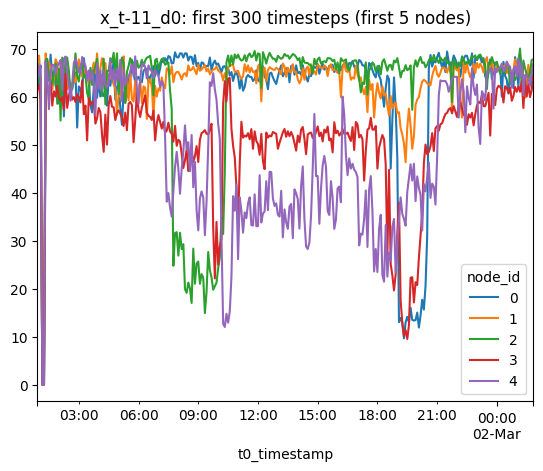

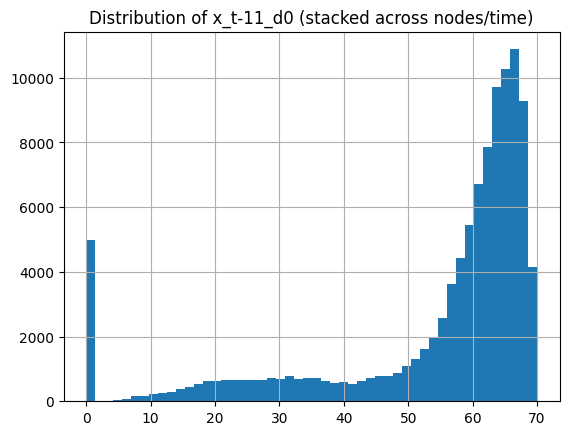

In [43]:
# Plot a few nodes
some_nodes = list(Y.columns[:5])
Y[some_nodes].iloc[:300].plot(title=f"{TARGET_COL}: first 300 timesteps (first 5 nodes)")
plt.show()

# Distribution
Y.stack().dropna().hist(bins=50)
plt.title(f"Distribution of {TARGET_COL} (stacked across nodes/time)")
plt.show()


In [44]:
# Train/val/test matrices (pivot each split)
def split_to_matrix(split, target_col):
    d = ds[split].to_pandas()
    d["t0_timestamp"] = pd.to_datetime(d["t0_timestamp"], errors="coerce")
    d["node_id"] = pd.to_numeric(d["node_id"], errors="coerce")
    d = d.dropna(subset=["t0_timestamp", "node_id"])
    d["node_id"] = d["node_id"].astype(int)

    m = (d[["t0_timestamp", "node_id", target_col]]
         .pivot(index="t0_timestamp", columns="node_id", values=target_col)
         .sort_index())
    return m

Y_train = split_to_matrix("train", TARGET_COL)
Y_val   = split_to_matrix("validation", TARGET_COL)
Y_test  = split_to_matrix("test", TARGET_COL)

print("Train/Val/Test shapes:", Y_train.shape, Y_val.shape, Y_test.shape)


Train/Val/Test shapes: (23974, 207) (3425, 207) (6850, 207)


In [45]:
# Simple standardization (global). Alternative: per-node scaling.
train_vals = Y_train.values.astype(float)

mu = np.nanmean(train_vals)
sigma = np.nanstd(train_vals)
sigma = sigma if sigma > 0 else 1.0

def standardize(M):
    arr = M.values.astype(float)
    return (arr - mu) / sigma

Z_train = standardize(Y_train)
Z_val   = standardize(Y_val)
Z_test  = standardize(Y_test)

print("Z_train:", Z_train.shape)


Z_train: (23974, 207)


In [46]:
def make_windows(arr, window=12, horizon=12, stride=1):
    """
    arr: np.ndarray [T, N]
    returns:
      X: [num_samples, window, N]
      y: [num_samples, horizon, N]
    """
    X, y = [], []
    T = arr.shape[0]
    for t in range(0, T - window - horizon + 1, stride):
        X.append(arr[t:t+window])
        y.append(arr[t+window:t+window+horizon])
    return np.stack(X), np.stack(y)

WINDOW = 12
HORIZON = 12
STRIDE = 1

X_train, y_train = make_windows(Z_train, WINDOW, HORIZON, STRIDE)
X_val, y_val     = make_windows(Z_val, WINDOW, HORIZON, STRIDE)
X_test, y_test   = make_windows(Z_test, WINDOW, HORIZON, STRIDE)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape, "y_val  :", y_val.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)


X_train: (23951, 12, 207) y_train: (23951, 12, 207)
X_val  : (3402, 12, 207) y_val  : (3402, 12, 207)
X_test : (6827, 12, 207) y_test : (6827, 12, 207)


# Baseline #1 (must-have): Naive persistence
Assumption: Traffic in the next hour will be the same as now.

ŷ[t+1:t+H] = X[t_last]


In [47]:
def persistence_baseline(X):
    """
    X: [num_samples, W, N]
    Returns predictions: [num_samples, H, N]
    """
    last_step = X[:, -1:, :]      # shape: [num_samples, 1, N]
    y_hat = np.repeat(last_step, HORIZON, axis=1)
    return y_hat


In [48]:
y_hat_persist = persistence_baseline(X_val)

mae = np.mean(np.abs(y_hat_persist - y_val))
rmse = np.sqrt(np.mean((y_hat_persist - y_val) ** 2))

print("Persistence MAE:", mae)
print("Persistence RMSE:", rmse)


Persistence MAE: 0.2532769148467558
Persistence RMSE: 0.6128439521103304


# Baseline #2 (strong + simple): Linear Regression (per node)

In [49]:
# Prepare flattened features
def flatten_windows(X):
    # [num_samples, W, N] → [num_samples, W*N]
    return X.reshape(X.shape[0], -1)

Xtr_f = flatten_windows(X_train)
Xva_f = flatten_windows(X_val)


In [50]:
# Train linear regression (sklearn)
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(Xtr_f, y_train[:, 0, :])  # predict 1-step ahead


Ridge()

In [51]:
# Autoregressive rollout for multi-step prediction
def autoregressive_forecast(model, X, horizon):
    """
    model: trained regressor
    X: [num_samples, W, N]
    """
    preds = []
    X_cur = X.copy()

    for h in range(horizon):
        Xf = flatten_windows(X_cur)
        y_next = model.predict(Xf)  # [num_samples, N]
        preds.append(y_next)

        # shift window
        X_cur = np.concatenate(
            [X_cur[:, 1:, :], y_next[:, None, :]],
            axis=1
        )

    return np.stack(preds, axis=1)


In [52]:
# Evaluate
y_hat_lr = autoregressive_forecast(ridge, X_val, HORIZON)

mae = np.mean(np.abs(y_hat_lr - y_val))
rmse = np.sqrt(np.mean((y_hat_lr - y_val) ** 2))

print("Linear Ridge MAE:", mae)
print("Linear Ridge RMSE:", rmse)


Linear Ridge MAE: 0.306878506879629
Linear Ridge RMSE: 0.5660682919658356


We trained 1-step ahead and then rolled out autoregressively for 12 steps.

That means:

error compounds

linear models degrade quickly over horizon

In [53]:
for h in [0, 3, 6, 11]:
    mae_h = np.mean(np.abs(y_hat_lr[:, h, :] - y_val[:, h, :]))
    print(f"Horizon {h+1} MAE:", mae_h)


Horizon 1 MAE: 0.17787024996296455
Horizon 4 MAE: 0.27201380971465244
Horizon 7 MAE: 0.32777756947527825
Horizon 12 MAE: 0.38868496848843126


In [ ]:
# Direct 1-step prediction error (no rollout)
y_hat_1 = ridge.predict(flatten_windows(X_val))
mae_1 = np.mean(np.abs(y_hat_1 - y_val[:, 0, :]))
rmse_1 = np.sqrt(np.mean((y_hat_1 - y_val[:, 0, :]) ** 2))

print("1-step Linear MAE:", mae_1)
print("1-step Linear RMSE:", rmse_1)


1-step Linear MAE: 0.17787024996296455
1-step Linear RMSE: 0.3309059977006679


Conclusion: Linear regression captures short-term temporal dynamics very well, but fails to maintain accuracy over longer horizons when used autoregressively.

In [ ]:
# TODO: deep learning models